# Detection

In [ ]:
import cv2
import glob
import h5py
import json
import numpy as np
import optparse
import os
import PIL.Image as Image
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from json import JSONEncoder
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as transforms

## Converter

In [ ]:
%%writefile converter.py
# coding: utf-8
# SVHN extracts data from the digitStruct.mat full numbers files.  The data can be downloaded
# the Street View House Number (SVHN)  web site: http://ufldl.stanford.edu/housenumbers.
#
# This is an A2iA tweak (YG -9 Jan 2014) of the script found here :
# http://blog.grimwisdom.com/python/street-view-house-numbers-svhn-and-octave
#
# The digitStruct.mat files in the full numbers tars (train.tar.gz, test.tar.gz, and extra.tar.gz)
# are only compatible with matlab.  This Python program can be run at the command line and will generate
# a json version of the dataset.
#
# Command line usage:
#       SVHN_dataextract.py [-f input] [-o output_without_extension]
#    >  python SVHN_dataextract.py -f digitStruct.mat -o digitStruct
#
# Issues:
#    The alibility to split in several files has been removed from the original
#    script.
#

import tqdm
import h5py
import optparse
from json import JSONEncoder

parser = optparse.OptionParser()
parser.add_option("-f", dest="fin", help="Matlab full number SVHN input file", default="digitStruct.mat")
parser.add_option("-o", dest="filePrefix", help="name for the json output file", default="digitStruct")
options, args = parser.parse_args()

fin = options.fin


# The DigitStructFile is just a wrapper around the h5py data.  It basically references
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    # getName returns the 'name' string for for the n(th) digitStruct.
    def getName(self, n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    # bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox.
    def bboxHelper(self, attr):
        if len(attr) > 1:
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    # getBbox returns a dict of data for the n(th) bbox.
    def getBbox(self, n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self, n):
        s = self.getBbox(n)
        s['name'] = self.getName(n)
        return s

    # getAllDigitStructure returns all the digitStruct from the input file.
    def getAllDigitStructure(self):
        print('Starting get all digit structure')
        return [self.getDigitStructure(i) for i in tqdm.tqdm(range(len(self.digitStructName)))]

    # Return a restructured version of the dataset (one structure by boxed digit).
    #
    #   Return a list of such dicts :
    #      'filename' : filename of the samples
    #      'boxes' : list of such dicts (one by digit) :
    #          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
    #          'left', 'top' : position of bounding box
    #          'width', 'height' : dimension of bounding box
    #
    # Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        print('Starting pack josn dict')
        for i in tqdm.tqdm(range(len(pictDat))):
            item = {'filename': pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = dict()
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt += 1
            item['boxes'] = figures
            result.append(item)
        return result


dsf = DigitStructFile(fin)
dataset = dsf.getAllDigitStructure_ByDigit()
fout = open(options.filePrefix + ".json", 'w')
fout.write(JSONEncoder(indent=True).encode(dataset))
fout.close()

Writing converter.py


## Model

We always check that we are running on a GPU

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


Load CIFAR and SVHN datasets.

In [ ]:
# Download complete SVHN dataset
if not os.path.exists('./SVHN'):
  import gdown
  url = 'https://drive.google.com/uc?id=1YneBiiNWt6mEa5STYWtT5XlDb_6JeDpg'
  gdown.download(url, './SVHN.zip', quiet=False)
  !unzip ./SVHN.zip > /dev/null
  !rm SVHN.zip

Downloading...
From: https://drive.google.com/uc?id=1YneBiiNWt6mEa5STYWtT5XlDb_6JeDpg
To: /content/SVHN.zip
689MB [00:03, 200MB/s]


In [ ]:
# Convert structs to json
!python converter.py -f /content/SVHN/train/digitStruct.mat -o digitStruct_train
!python converter.py -f /content/SVHN/test/digitStruct.mat -o digitStruct_test

Starting get all digit structure
  0% 0/33402 [00:00<?, ?it/s]converter.py:51: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
converter.py:46: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])
  0% 13/33402 [00:00<04:22, 127.12it/s]converter.py:53: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  attr = [attr.value[0][0]]
100% 33402/33402 [03:47<00:00, 146.78it/s]
Starting pack josn dict
100% 33402/33402 [00:00<00:00, 197566.48it/s]
Starting get all digit structure
  0% 0/13068 [00:00<?, ?it/s]converter.py:53: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  attr = [attr.value[0][0]]
converter.py:46: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
 

In [ ]:
with open('digitStruct_train.json') as json_file:
    data_train = json.load(json_file)
with open('digitStruct_test.json') as json_file:
    data_test = json.load(json_file)
data_train = {item['filename']:item for item in data_train}
data_test = {item['filename']:item for item in data_test}

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     ])

batch_size = 64
trainset1 = datasets.SVHN('./data', split='train', download=True, transform=train_transform)
trainset2 = datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
trainset2.targets = np.asarray(trainset2.targets)
trainset2.targets[:] = 10
trainset = ConcatDataset([trainset1, trainset2])
testset1 = datasets.SVHN('./data', split='test', download=True, transform=train_transform)
testset2 = datasets.CIFAR10('./data', train=False, download=True, transform=train_transform)
testset2.targets = np.asarray(testset2.targets)
testset2.targets[:] = 10
testset = ConcatDataset([testset1, testset2])
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified


In [ ]:
np.unique(trainset1.labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Let's look at some images from our data 

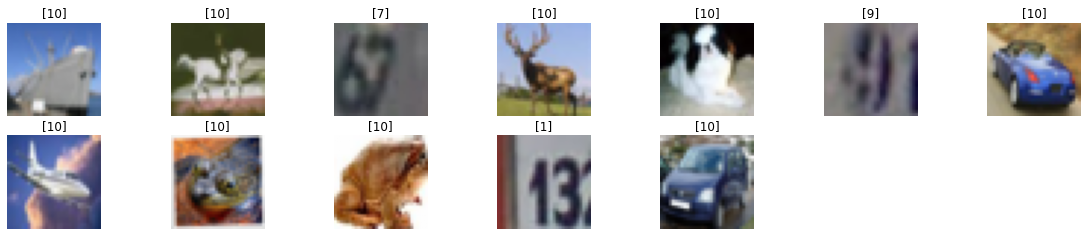

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(12):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title([labels[i].item()])
    plt.axis('off')

Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Now create a model and train it!


In [ ]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.cross_entropy(output, target) # logsoftmax and nll included
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            output = torch.squeeze(output)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Compute the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
                output = torch.squeeze(output)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [ ]:
class Detector(nn.Module):
    def __init__(self, n_in, n_f):
        super(Detector, self).__init__()
        self.convolutional = nn.Sequential( # 32*32 ->
            nn.Conv2d(in_channels=n_in, out_channels=16, kernel_size=5, stride=1), # -> 28*28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(),
            nn.MaxPool2d(2), # -> 14*14
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1), # -> 10*10
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(),
            nn.MaxPool2d(2), # -> 5*5
            nn.Conv2d(in_channels=32, out_channels=600, kernel_size=5, stride=1), # -> 1*1
            nn.ReLU(),
            nn.Conv2d(in_channels=600, out_channels=1100, kernel_size=1, stride=1), # -> 1*1 classifier
            nn.ReLU(),
            nn.Conv2d(in_channels=1100, out_channels=n_f, kernel_size=1, stride=1), # -> 1*1 output
            # nn.ReLU(), # this one too?
        )
    def forward(self, x):
        x = self.convolutional(x)
        return x

In [ ]:
model = Detector(3, 11)
model.to(device)

Detector(
  (convolutional): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout2d(p=0.5, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 600, kernel_size=(5, 5), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(600, 1100, kernel_size=(1, 1), stride=(1, 1))
    (13): ReLU()
    (14): Conv2d(1100, 11, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_sdg = train(model, optimizer)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
out_adam = train(model, optimizer)


Loss train: 0.801	 test: 0.510	 Accuracy train: 75.2%	 test: 85.0%



Loss train: 0.499	 test: 0.470	 Accuracy train: 85.3%	 test: 86.3%



Loss train: 0.430	 test: 0.393	 Accuracy train: 87.4%	 test: 88.5%



Loss train: 0.389	 test: 0.370	 Accuracy train: 88.5%	 test: 89.3%



Loss train: 0.357	 test: 0.341	 Accuracy train: 89.4%	 test: 90.3%



Loss train: 0.335	 test: 0.346	 Accuracy train: 90.1%	 test: 90.0%



Loss train: 0.318	 test: 0.338	 Accuracy train: 90.6%	 test: 90.3%



Loss train: 0.298	 test: 0.322	 Accuracy train: 91.1%	 test: 91.0%



Loss train: 0.288	 test: 0.307	 Accuracy train: 91.4%	 test: 91.2%



Loss train: 0.272	 test: 0.327	 Accuracy train: 91.9%	 test: 90.8%



In [ ]:
# images_full = glob.glob('SVHN/test/*.png')
# output = []
# for i, image in enumerate(images_full):
#     img = cv2.imread(image)
#     img_trans = torch.FloatTensor(img).permute((2,0,1)).to(device)
#     output.append(model(img_trans.unsqueeze(0)))

In [ ]:
def calculate_dims(img):
    
    def conv(h_in, w_in, K, S=1):
        h_out = math.floor((h_in - K)/S + 1)
        w_out = math.floor((w_in - K)/S + 1)
        return (h_out, w_out)
    
    def maxpool(h_in, w_in, K=2, S=2):
        h_out = math.floor((h_in - K)/S + 1)
        w_out = math.floor((w_in - K)/S + 1)
        return (h_out, w_out)

    h, w, c = img.shape
    init_dims = (h, w)
    dims1 = conv(*init_dims, K=5)
    dims2 = maxpool(*dims1)
    dims3 = conv(*dims2, K=5)
    dims4 = maxpool(*dims3)
    dims5 = conv(*dims4, K=5)
    dims6 = conv(*dims5, K=1)
    final_dims = conv(*dims6, K=1)

    return final_dims

In [ ]:
def IOU(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    w_intersection = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_intersection = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_intersection <= 0 or h_intersection <= 0: # No overlap
        return 0
    I = w_intersection * h_intersection
    U = w1 * h1 + w2 * h2 - I # Union = Total Area - I
    
    return I / U

In [ ]:
def show_bbox(img, output): 

    # Box values
    box_values = output[0].argmax(0).cpu().numpy()
    prob = F.softmax(output, dim=1)[0].data.cpu().numpy()
    
    # Number of boxes horisontally and vertically
    horisontal_boxes = output.size()[3]
    vertical_boxes = output.size()[2]

    # Stride size - how many pixels are skipped each time we move the box
    horisontal_strides = (img.shape[1] - 32) / (horisontal_boxes - 1)
    vertical_strides = (img.shape[0] - 32) / (vertical_boxes - 1)  

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # First maximum bbox
    for c in range(0, 10):
        coord = np.where(prob[c] == np.amax(prob[c]))
        v_coord = coord[0][0]
        h_coord = coord[1][0]
        prob_val = prob[c][v_coord][h_coord]
        if (prob_val >= 0.6 and c in box_values): # box_values condition
            print(f'{c}, prob={prob_val:.2f}, x={h_coord}, y={v_coord}')
            box1 = (h_coord*horisontal_strides, v_coord*vertical_strides, 32, 32)
            rect = patches.Rectangle((h_coord * horisontal_strides,
                                      v_coord * vertical_strides),
                                     32,
                                     32,
                                     linewidth=1,
                                     edgecolor='C'+str(c),
                                     facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
            ax.annotate(str(c), (h_coord * horisontal_strides,
                                 v_coord * vertical_strides))
            
            # # Check for extra boxes with IOU < 0.5
            # for i in range(0, horisontal_boxes):
            #     for j in range(0, vertical_boxes):
            #         prob_val = prob[c][j][i]
            #         box2 = (i*horisontal_strides, j*vertical_strides, 32, 32)
            #         iou = IOU(box1, box2)
            #         if (prob_val >= 0.6 and iou < 0.5):
            #             print(f'{c}, prob={prob_val:.2f}, x={i}, y={j}, IOU={iou:.2f}')
            #             rect = patches.Rectangle((i * horisontal_strides,
            #                           j * vertical_strides),
            #                          32,
            #                          32,
            #                          linewidth=1,
            #                          edgecolor='C'+str(c),
            #                          facecolor='none')
            #             # Add the patch to the Axes
            #             ax.add_patch(rect)
            #             ax.annotate(str(c), (i * horisontal_strides,
            #                                 j * vertical_strides))

    # for c in range(0, 10):
    #     p_largest = -1
    #     for i in range(0, horisontal_boxes): 
    #         for j in range(0, vertical_boxes): 
    #             box_val = box_values[j][i]
    #             prob_val = prob[box_val][j][i]
    #             if (box_val == c and prob_val > p_largest):
    #                 p_largest = prob_val
    #                 if (p_largest >= 0.6): 
    #                 # Create a Rectangle patch
    #                     rect = patches.Rectangle((i * horisontal_strides, j * vertical_strides),
    #                                             32,
    #                                             32,
    #                                             linewidth=1,
    #                                             edgecolor='r',
    #                                             facecolor='none')

    #                     # Add the patch to the Axes
    #                     ax.add_patch(rect)

In [ ]:
num = 5
img = cv2.imread(f'SVHN/test/{num}.png')
img_trans = torch.FloatTensor(img).permute(2,0,1).to(device)
output = model(img_trans.unsqueeze(0)).detach()
data_test[f'{num}.png']['boxes']

[{'height': 28.0, 'label': 9.0, 'left': 97.0, 'top': 28.0, 'width': 19.0}]

In [ ]:
img.shape

(81, 215, 3)

In [ ]:
output.shape

torch.Size([1, 11, 13, 46])

In [ ]:
calculate_dims(img)

(13, 46)

In [ ]:
output[0].argmax(0).cpu().numpy()

array([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  1, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10,  7,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10,  7,  1,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10,  7, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10,  1,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [ 1,  1,  1, 10,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10,  8,  1,  1,  1,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10,  1,  1, 

0, prob=0.78, x=6, y=9
1, prob=1.00, x=11, y=0
2, prob=0.72, x=28, y=5
3, prob=1.00, x=23, y=6
7, prob=1.00, x=34, y=1
8, prob=1.00, x=2, y=4
9, prob=1.00, x=6, y=5


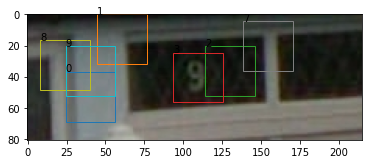

In [ ]:
show_bbox(img, output)

Text(0, 0.5, 'Error')

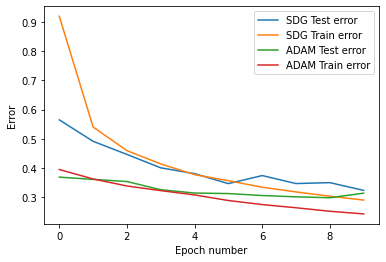

In [ ]:
# Loss
plt.plot(range(10), out_sdg['test_loss'])
plt.plot(range(10), out_sdg['train_loss'])
plt.plot(range(10), out_adam['test_loss'])
plt.plot(range(10), out_adam['train_loss'])
# plt.legend(('ADAM Test error', 'ADAM Train error'))
plt.legend(('SDG Test error','SDG Train error', 'ADAM Test error', 'ADAM Train error'))
plt.xlabel('Epoch number')
plt.ylabel('Error')

Text(0, 0.5, 'Accuracy')

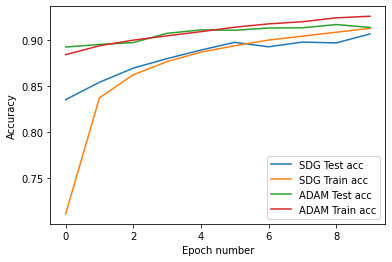

In [ ]:
# Accuracy
plt.plot(range(10), out_sdg['test_acc'])
plt.plot(range(10), out_sdg['train_acc'])
plt.plot(range(10), out_adam['test_acc'])
plt.plot(range(10), out_adam['train_acc'])
plt.legend(('SDG Test acc','SDG Train acc', 'ADAM Test acc', 'ADAM Train acc'))
plt.legend(('SDG Test acc','SDG Train acc', 'ADAM Test acc', 'ADAM Train acc'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')